# 프로젝트: Spectrogram classification 모델 구현

## 0. Wave data 분석
---

```
$ mkdir -p ~/aiffel/speech_recognition/data
$ mkdir -p ~/aiffel/speech_recognition/models
$ wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz -P ~/aiffel/speech_recognition/data
```

#### Wave 데이터 형식 뜯어보기
* Audio 데이터는 이미지 데이터보다 낮은 차원의 데이터를 다룬다. 1개의 wav 파일은 1차원으로 이루어진 시계열 데이터이다. 실제로는 여러 소리 파형이 합쳐진 복합파라고 보아야 한다.

#### 간단한 단어 인식을 위한 훈련데이터셋
* 짧은 단어의 라벨이 달려 있어, 음성들을 텍스트로 구분하는 모델 혹은 간단한 명령어를 구별하는 모델로도 학습이 가능하다.

#### Bits per sample
* 샘플 하나마다 소리의 세기를 몇 비트로 저장했는지를 나타낸다.
* 값이 커질 수록 세기를 정확하게 저장할 수 있다. <br>예를 들어, Bits rate가 16 bits 라면, 소리의 세기를 $2^{16}$, 즉 65,536 단계로 표현할 수 있다.
* 4 bits / 8 bits unsigned int / 16 bits int / 24 bits / 32 bits float 등의 자료형으로 표현된다.

#### Sampling frequency
* 샘플링 주파수라는 단어입니다. 소리로부터 초당 샘플링한 횟수를 의미한다.
* 샘플링은 원래 신호를 다시 복원할 수 있는 나이퀴스트(Nyquist) 샘플링 룰에 따라서, 복원해야 할 신호 주파수의 2배 이상으로 샘플링 해야한다.
* 가청 주파수 20 ~ 24 kHz를 복원하기 위해 사용하며, 음원에서 많이 쓰이는 값은 44.1 kHz이다.

#### Channel
* 각 채널별로 샘플링된 데이터가 따로 저장되어 있다.
* 2채널(Stereo) 음원을 재생하면 왼쪽(L)과 오른쪽(R) 스피커에 다른 값이 출력된다.
* 1채널(Mono) 음원의 경우 왼쪽(L) 데이터만 있으며, 재생시엔 왼쪽(L)과 오른쪽(R) 스피커에 같은 값이 출력된다.

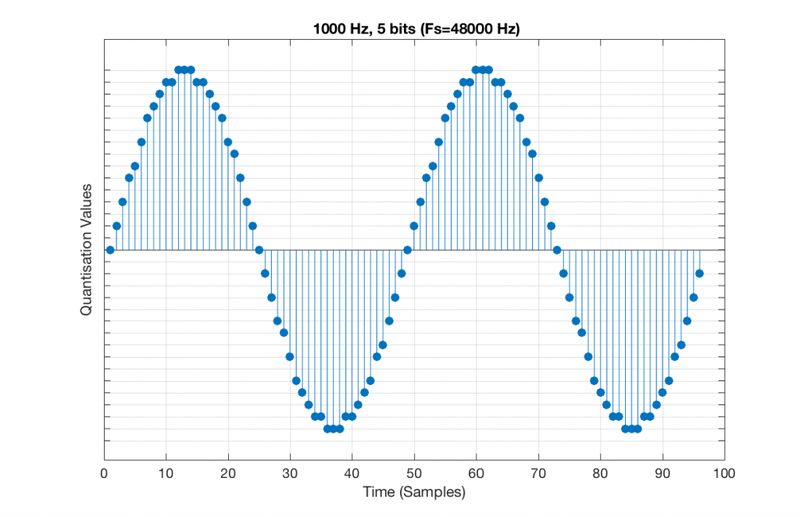

* 1000 Hz 신호를 저장한 wav 파일이다.
* Sample rate 는 48000 Hz, 즉 1초 재생하는데 필요한 Sample 수는 48000개이다.
* 모든 샘플은 -1 ~ 1 사이의 정해진 bits per sample의 값으로 표현된다.

## 1. 데이터 처리와 분류
---
* 라벨 데이터 처리하기
* `sklearn`의 `train_test_split`함수를 이용하여 train, test 분리

__프로젝트 진행을 위해 GPU 조정__

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

### 라벨 데이터 처리하기

In [2]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [3]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


* npz 파일로 이뤄진 데이터이며, 각각 데이터는 "wav_vals", "label_vals"로 저장되어있다.
* 데이터셋은 1초 길이의 오디오 음성데이터 50620개로 이뤄져 있다.
* 주어진 데이터의 원래 Sample rate는 16000이지만, 8000으로 re-sampling하여 사용.
* 모두 1초의 길이를 가지는 오디오 음성데이터이여서 각각 8000개의 sample data를 가지고 있다.

데이터셋은 캐글의 음성 인식 챌린지의 데이터이다. 
[Kaggle/TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)

In [4]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  13872
Wave data shape :  (8000,)
label :  ['right']


### `sklearn`의 `train_test_split`함수를 이용하여 train, test 분리

In [5]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


Text로 이루어진 라벨 데이터를 학습에 사용하기 위해서 index 형태로 바꿔주었다.<br>
int로 이뤄진 index 작업을 통해서 Label data를 더 쉽게 사용할 수 있다.

In [6]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

__sklearn의 train_test_split 함수를 이용해 train data와 test data를 분리해보겠다.<br>
test_size의 인자를 조절해주면, 설정해 준 값만큼 Test dataset의 비율을 조정할 수 있다.__

In [7]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr])
test_wav = test_wav.reshape([-1, sr])

[[ 5.5530360e-03  4.4701137e-03  3.0375613e-04 ...  4.0597641e-03
   5.6560189e-03  2.5470294e-03]
 [ 4.2101915e-04  4.9363897e-04  3.9469518e-04 ...  1.8934510e-03
   1.3192813e-03  1.3920151e-03]
 [ 3.3022459e-03  4.7358740e-03 -7.2088507e-05 ...  2.4575249e-03
   1.9059028e-03 -1.9960129e-03]
 ...
 [-1.0202196e-07  5.4128758e-08  1.2363505e-08 ...  3.1279041e-03
   4.7520120e-03  4.1735703e-03]
 [-6.4831962e-05 -8.2505023e-04 -1.1011898e-03 ...  1.1929411e-03
   1.7975696e-03  9.6184772e-04]
 [ 2.5803762e-04  6.0133514e-04  6.9295376e-04 ...  4.5853842e-04
   9.3238457e-04  1.0665753e-03]]


In [8]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 8000)
train labels :  (45558,)
test data :  (5062, 8000)
test labels :  (5062,)


### 1차원의 데이터 spectrogram으로 변환
---

#### train data 변환

In [9]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [10]:
train_spec=[] 

for wav in train_wav: 
    train_spec.append(wav2spec(wav))
train_spec = np.array(train_spec)
print("train pectrogram shape : ", train_spec.shape)

train pectrogram shape :  (45558, 130, 126)


#### test data 변환

In [11]:
test_spec=[] 

for wav in test_wav: 
    test_spec.append(wav2spec(wav))
test_spec = np.array(test_spec)
print("test spectrogram shape : ",test_spec.shape)

test spectrogram shape :  (5062, 130, 126)


## 2. 학습을 위한 하이퍼파라미터 설정
---

In [12]:
batch_size = 32
max_epochs = 5

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'

checkpoint_dir

'/home/aiffel-dj10/aiffel/speech_recognition/models/spec'

## 3. 데이터셋 구성
---
* `tf.data.Dataset`을 이용
* from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
* map과 batch를 이용한 데이터 전처리
* __주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있다.<br>
tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 된다.__

```
del speech_data
del spec_data
```

#### from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용

In [13]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

#### map과 batch를 이용한 데이터 전처리

In [14]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


### 메모리 버퍼를 비우기

In [15]:
del train_wav
del train_label
del test_wav
del test_label


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
---
* 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
* batchnorm, dropout, dense layer 등을 이용
* 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
* 모델 가중치를 저장하는 checkpoint callback 함수 추가

### 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용(batchnorm, dropout, dense layer 등을 이용)
#### Conv2D model

In [16]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126)) #(130,126)

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model1_spec = tf.keras.Model(input_tensor, output_tensor)

model1_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

#### 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용

In [17]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model1_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

#### 모델 가중치를 저장하는 checkpoint callback 함수 추가

In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [19]:
history_spec = model1_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/5
1416/1423 [============================>.] - ETA: 0s - loss: 1.4084 - accuracy: 0.5167
Epoch 00001: val_loss improved from inf to 0.92470, saving model to /home/aiffel-dj10/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 10s 7ms/step - loss: 1.4054 - accuracy: 0.5177 - val_loss: 0.9247 - val_accuracy: 0.6893
Epoch 2/5
1420/1423 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.7682
Epoch 00002: val_loss improved from 0.92470 to 0.56361, saving model to /home/aiffel-dj10/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 9s 6ms/step - loss: 0.6912 - accuracy: 0.7683 - val_loss: 0.5636 - val_accuracy: 0.8111
Epoch 3/5
1423/1423 [==============================] - ETA: 0s - loss: 0.4605 - accuracy: 0.8457
Epoch 00003: val_loss improved from 0.56361 to 0.42843, saving model to /home/aiffel-dj10/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 9s 7ms/step - los

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
---
* loss, accuracy를 그래프로 표현

#### loss, accuracy를 그래프로 표현

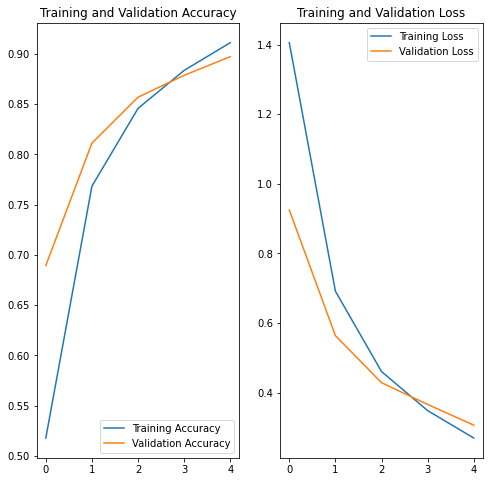

In [20]:
import matplotlib.pyplot as plt

acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. Test dataset을 이용해서 모델의 성능을 평가
---
* 저장한 weight 불러오기
* 모델의 예측값과 정답값이 얼마나 일치하는지 확인

#### 저장한 weight 불러오기

In [21]:
model1_spec.load_weights(checkpoint_dir)

#### 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [22]:
results = model1_spec.evaluate(test_dataset)

159/159 [==============================] - 19s 117ms/step - loss: 0.3063 - accuracy: 0.8973


In [23]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.306
accuracy value: 89.7274%


## 7. Skip-Connection model
---

In [24]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 130, 32)      36320       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 130, 32)      9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 65, 32)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [25]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [26]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [27]:
history_spec_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch= 45558 // batch_size,
                    validation_data=test_dataset,
                    validation_steps= 5062 // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/5
1421/1423 [============================>.] - ETA: 0s - loss: 1.4739 - accuracy: 0.4984
Epoch 00001: val_loss improved from inf to 0.95817, saving model to /home/aiffel-dj10/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 10s 7ms/step - loss: 1.4730 - accuracy: 0.4986 - val_loss: 0.9582 - val_accuracy: 0.6741
Epoch 2/5
1421/1423 [============================>.] - ETA: 0s - loss: 0.7869 - accuracy: 0.7354
Epoch 00002: val_loss improved from 0.95817 to 0.58178, saving model to /home/aiffel-dj10/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 10s 7ms/step - loss: 0.7866 - accuracy: 0.7355 - val_loss: 0.5818 - val_accuracy: 0.8085
Epoch 3/5
1422/1423 [============================>.] - ETA: 0s - loss: 0.5127 - accuracy: 0.8273
Epoch 00003: val_loss improved from 0.58178 to 0.43451, saving model to /home/aiffel-dj10/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 1

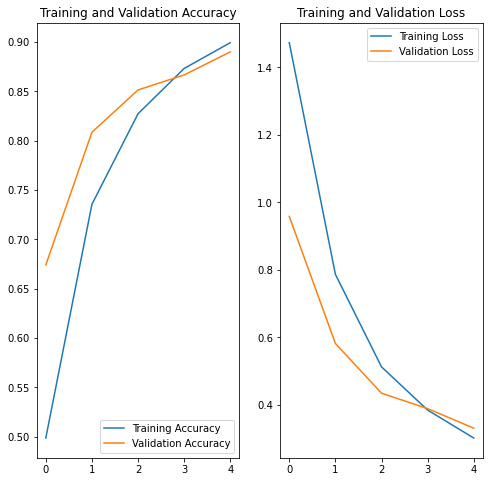

In [28]:
acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
# Evaluation 
model_spec_skip.load_weights(checkpoint_dir)
results = model_spec_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))

# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

159/159 [==============================] - 5s 33ms/step - loss: 0.3312 - accuracy: 0.8900
loss value: 0.331
accuracy value: 88.9964%


Test

## 정확도 비교
* Spectrogram : 89.7274%
* Skip-Connection model : 88.9964%

## 루브릭 평가
---

__1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.__<br>

음성데이터를 Train data와 Test data으로 나누고 2차원 Spectrogram으로 변환 및 시각화했다.<br><br>

__2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.__<br>

Spectrogram, Skip-Connection model 두 모델 전부 정상 작동한다.<br><br>

__3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.__<br>

Spectrogram, Skip-Connection model 두 모델 전부 90%, 88%가 나왔다.

## 느낀점
1. E4를 너무 집중하다보니 체력과 집중력은 다 소모했나보다... 내용 이해도 어렵고 코드도 잘 이해되지 않았다.
2. 그러나 다른 분들이 올리신 slack을 뒤져보기도 하고, 코드들도 다시한번 보면서 이번 프로젝트를 잘 이겨나간듯하다. (아직도 코드를 잘 짰는지 모르겠다.ㅋㅋㅋ)
3. 커널이 죽었을때 얼마나 당황했는지ㅋㅋㅋ 고것도 참 힘들었다. 그냥 전부 힘들었던 프로젝트였다ㅋㅋㅋ
4. 후에 좀더 성장해서 이 프로젝트를 다시 한번 보면 좋을 것 같다. 그때 보면 또 다른 느낌과 배울 점들이 있을 것 같다ㅎㅎ